In [10]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
from pandarallel import pandarallel

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [11]:
ab = '../../lr_bulk/talon/human_talon_abundance.tsv'
filt_ab = '../../lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
read_annot = '../../lr_bulk/talon/human_talon_read_annot.tsv'
t_metadata = '../../refs/cerberus/v40_transcript_metadata.tsv'
swan_file = '../../lr_bulk/cerberus/swan/swan_meta.p'
cerberus_h5 = '../../lr_bulk/cerberus/triplets/cerberus_annot_triplets.h5'
major_isos = '../../lr_bulk/cerberus/swan/major_isos.tsv'

ver = 'v40_cerberus'

min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'

mouse_ab = '../../mouse/lr_bulk/talon/mouse_talon_abundance.tsv'
mouse_filt_ab = '../../mouse/lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
mouse_read_annot = '../../mouse/lr_bulk/talon/mouse_talon_read_annot.tsv'
mouse_swan_file = '../../mouse/lr_bulk/swan/swan.p'
mouse_meta = '../../mouse/lr_bulk/lr_mouse_library_data_summary.tsv'
mouse_t_metadata = '../../mouse/refs/cerberus/vM25_transcript_metadata.tsv'
mouse_ver = 'vM25_cerberus'


## Distances between observed gene triplets and sample-level centroid gene triplets

In [4]:
ca = cerberus.read(cerberus_h5)
ca = get_centroids(ca, 
                   source='sample_det',
                   gene_subset=gene_subset,
                   ver=ver)
df = compute_dists([ca, ca],
                   ['sample_det_centroid', 'obs_det'],
                   rm_1_isos=[False, True],
                   gene_subsets=[gene_subset, gene_subset],
                   ver=[ver, ver])

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


In [5]:
n = len(df.index)
n_num = len(df.loc[df.z_score > 2].index)
print(f'{(n_num/n)*100:.2f}% genes ({n_num}/{n}) have z-score > 2 between obs. det and sample-level centroids')

3.18% genes (500/15734) have z-score > 2 between obs. det and sample-level centroids


In [6]:
n = len(df.loc[df.sector_obs_det=='tss'].index)
n_num = len(df.loc[(df.sector_obs_det=='tss')&(df.sector_sample_det_centroid!='tss')].index)
print(f'{(n_num/n)*100:.2f}% genes ({n_num}/{n}) in the obs_det TSS-high sector are not TSS-high for sample-level centroids')

94.83% genes (2129/2245) in the obs_det TSS-high sector are not TSS-high for sample-level centroids


In [7]:
# gene with the highest distance between obs_det and sample_det_centroid
df.sort_values(by='dist', ascending=False).head(1)['gname']

179    ACTA1
Name: gname, dtype: object

## ACTA1 labelled gene triplets

In [8]:
ca.triplets.loc[(ca.triplets.source.isin(['obs_det', 'sample_det_centroid']))&(ca.triplets.gname=='ACTA1')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm
8074,obs_det,ENSG00000143632,1.0,1.0,18.000000,18.000000,18.000000,0.050000,0.050000,0.900000,splicing,ACTA1,NaN,NaN
213,sample_det_centroid,ENSG00000143632,1.0,1.0,2.894737,2.894737,2.894737,0.283798,0.283798,0.432405,mixed,ACTA1,NaN,NaN


## # feats / transcripts / gene / sample

Calculating iso TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2033: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2032: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 187945
Found 50 total samples
Calculating iso TPM values
Subsetting for protein_coding genes
Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 187945
Found 50 total samples
10.21% (1789/17523)of genes have just 1 iso
24.41% (133184/545557)of gene / sample combos have just 1 iso


NameError: name 'fig_dir' is not defined

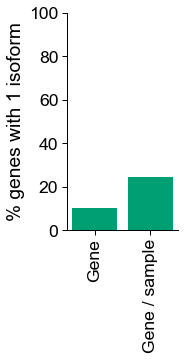

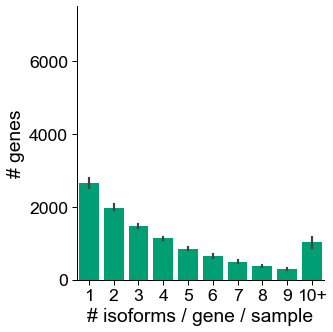

In [12]:
obs_col = 'sample'
min_tpm = 1
gene_subset = 'protein_coding'
fig_dir = 'figures/'

feat_sample = pd.DataFrame()
df = pd.DataFrame()
for feat in ['iso', 'tss', 'ic', 'tes']:

    # these won't give the exact same values / gene as the triplets because we're looking
    # at the expression of individual features. But to be consistent with what's done 
    # to generate the plots earlier in the paper this is how we should do it
    g_counts = get_counts_per_gene(filt_ab, obs_col, feat, min_tpm, gene_subset)
    gs_counts = get_counts_per_sample_per_gene(filt_ab, obs_col, feat, min_tpm, gene_subset)
    
    g_counts['source'] = 'Observed'
    g_counts['feat'] = feat
    gs_counts['source'] = 'Sample'
    gs_counts['feat'] = feat
    
    # what % of genes only have 1 triplet feat?
    n_num = len(g_counts.loc[g_counts.counts==1].index)
    n = len(g_counts.index)
    p_g = perc(n_num, n)
    print(f'{p_g:.2f}% ({n_num}/{n})of genes have just 1 {feat}')
    
    # what % of gene / sample combos only have 1 triplet feat?
    n_num = len(gs_counts.loc[gs_counts.counts==1].index)
    n = len(gs_counts.index)
    p_gs = perc(n_num, n)
    print(f'{perc(n_num,n):.2f}% ({n_num}/{n})of gene / sample combos have just 1 {feat}')
    temp1 = pd.DataFrame()
    temp1['combo'] = ['Gene', 'Gene / sample'] 
    temp1['perc'] = [p_g, p_gs]
    temp1['feat'] = feat
    plot_perc_one_feat(temp1, feat, opref=fig_dir)
        
    temp = pd.concat([g_counts, gs_counts], axis=0)    
    
    # # remove genes that only have 1 isoform overall
    # gids = ca.triplets.loc[(ca.triplets.source=='obs_det')&(ca.triplets.n_iso>1), 'gid'].unique().tolist()
    # print(len(temp.index))
    # temp = temp.loc[temp.gid.isin(gids)]
    # print(len(temp.index))
    
    # make plots
    
    plot_feats_per_sample_gene(temp, feat, obs_col)
    plot_feats_per_sample_gene_ecdf(temp, feat, obs_col)
    
    # test for differences
    obs = np.array(temp.loc[temp.source=='Observed', 'counts'].tolist())
    samp = np.array(temp.loc[temp.source=='Sample', 'counts'].tolist())
    
    s, pval = stats.kstest(obs, samp, alternative='two-sided')
    print(f'{feat} ks test statistic: {s}, pval: {pval}')
    print()
    
    # make an aggregate dataframe across the feats for n_feats vs. n_samples
    # feat_sample = pd.concat([feat_sample, get_n_samples_vs_n_feats(temp)], axis=0)
    plot_n_samples_vs_n_feats(temp, feat, opref=fig_dir)
    
    df = pd.concat([df, temp], axis=0)   

## ACTA1 # transcripts expressed in each sample

In [ ]:
plot_n_transcripts_per_sample(ca,
                              'ACTA1',
                              'sample_det',
                              'figures/acta1_transcripts_per_sample.pdf')

In [ ]:
ca.triplets.loc[(ca.triplets.gname=='ACTA1')&\
                (ca.triplets['sample'].isin(['heart', 'muscle']))&\
                (ca.triplets.source=='sample_det')]

## ACTA1 simplex

In [ ]:
gene = 'ACTA1'
c_dict, order = get_biosample_colors()
c_dict[np.nan] = 'k'
mmap = {'v40': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2', 'sample_det_centroid': 'x'} 
subset = {'source': ['v40', 'obs_det', 'sample_det', 'sample_det_centroid']}
fname='figures/simplex_{}_det.pdf'.format(gene.lower())
df = ca.plot_simplex(top='splicing_ratio', 
                     gene=gene,
                     hue='sample',
                     cmap=c_dict,
                     density=True,
                     density_scale=50,
                     density_cmap='Purples',
                     size='gene_tpm', 
                     log_size=True,
                     sectors=True,
                     marker_style='source',
                     mmap=mmap,
                     legend=False,
                     jitter=True,
                     subset=subset,
                     size_scale=0.5,
                     fname=fname) 

## ACTA1 transcripts

In [ ]:
plot_browser_isos_2(cerberus_h5,
                    swan_file,
                    filt_ab,
                    major_isos,
                    'ACTA1',
                    obs_col,
                    'heart',
                    'figures/acta1_heart_browser_isos.pdf',
                    h=0.2,
                    ref_sources=['v29', 'v40'])
